# Particle Mesh N-body Simulation

LPT accurately describes structure formation at early times and on large scales, but breaks down when particles begin to cross (shell-crossing). The Particle Mesh (PM) method integrates the full equations of motion using symplectic time-stepping on a grid.

This notebook compares the two available solvers and their correction kernels:

| Solver | Scheme | Reversible | Notes |
|--------|--------|-----------|-------|
| `EfficientDriftDoubleKick` | DKK | No | FastPM scheme, fewer force evaluations |
| `ReversibleDoubleKickDrift` | KKD | Yes | Same as above but is reversible |


## Setup

In [1]:
import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.95"
import jax_fli as jfli
import jax
import jax.numpy as jnp
import jax_cosmo as jc
import matplotlib.pyplot as plt

print(f"Devices {jax.devices()}")
jax.print_environment_info()

/lustre/fswork/projects/rech/tkc/commun/venv/pm/lib/python3.11/site-packages/jax/_src/compiler.py:783: UserWarning: Error reading persistent compilation cache entry for 'jit_convert_element_type': PermissionError: [Errno 13] Permission denied: '/jax_cache'
  warnings.warn(


Devices [CudaDevice(id=0)]
jax:    0.9.0.1
jaxlib: 0.9.0.1
numpy:  2.4.2
python: 3.11.5 | packaged by conda-forge | (main, Aug 27 2023, 03:34:09) [GCC 12.3.0]
device info: NVIDIA H100 80GB HBM3-1, 1 local devices"
process_count: 1
platform: uname_result(system='Linux', node='jzxh026', release='5.14.0-570.58.1.el9_6.x86_64', version='#1 SMP PREEMPT_DYNAMIC Tue Oct 21 04:15:07 EDT 2025', machine='x86_64')
JAX_PERSISTENT_CACHE_ENABLE_XLA_CACHES=xla_gpu_per_fusion_autotune_cache_dir
JAX_PERSISTENT_CACHE_MIN_ENTRY_SIZE_BYTES=-1
JAX_COMPILATION_CACHE_DIR=/jax_cache
JAX_PERSISTENT_CACHE_MIN_COMPILE_TIME_SECS=0
XLA_PYTHON_CLIENT_MEM_FRACTION=0.95

$ nvidia-smi
Wed Feb 18 11:32:11 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.126.16             Driver Version: 580.126.16     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Per

## Initial Conditions and LPT Initialization

PM simulations start from LPT displacements and momenta at an early scale factor $a_0$. We use `lpt` with a **scalar** `ts` to get the particle state without painting.

In [2]:
key = jax.random.PRNGKey(0)
resolution = 600
mesh_size = (resolution,) * 3
box_size = (1000.0, 1000.0, 1000.0)
nside = resolution
flatsky_npix = (resolution, resolution)
field_size = (10, 10)
nb_shells = 4
cosmo = jc.Planck18()
ts = jnp.array([0.2, 0.6, 0.8])

initial_field = jfli.gaussian_initial_conditions(
    key,
    mesh_size,
    box_size,
    cosmo=cosmo,
    nside=nside,
    flatsky_npix=flatsky_npix,
    field_size=field_size,
)

# LPT at early time to initialize PM
t0 = 0.1
dx, p = jfli.lpt(cosmo, initial_field, ts=t0, order=1, painting=jfli.PaintingOptions(target="particles"))
print(f"LPT initialized at a={t0}")
print(f"Displacement status: {dx.status}")

LPT initialized at a=0.1
Displacement status: FieldStatus.LPT1


## Solver Overview

Both solvers compose **Kick** (update momenta from forces) and **Drift** (update positions from momenta) operations:

- **DKK** (`EfficientDriftDoubleKick`): Drift-Kick-Kick ordering. Uses the FastPM time-stepping scheme with fewer force evaluations per step. Not time-reversible.
- **KKD** (`ReversibleDoubleKickDrift`): Kick-Kick-Drift ordering. Also efficient but designed to be time-reversible and produces drifted positions at the velocities at each steps.. which is crucial for interpolation.

They are equivalent solvers the DKK does an initial Kick then a Drift double kick
The KKD solver does an intitial kick drift then every step is double kick drift (of the next step)

KKD is better for interpolation because the velocities at the end of the steps are the ones used to drift and in that case we can do the last drift (more info in @CLAUDE SOME other notebook)

/lustre/fswork/projects/rech/tkc/commun/venv/pm/lib/python3.11/site-packages/jax/_src/debugging.py:201: UserWarning: 
                NoInterp does not support tiling.
                Your furthest shell is at 7759.72 Mpc/h,
                but your box only extends to 500.00 Mpc/h.
                Your simulations will run but will have artifacts for the far shells.
            
  debug_callback_p.impl(


KKD output type: DensityField, shape: (3, 600, 600, 600)


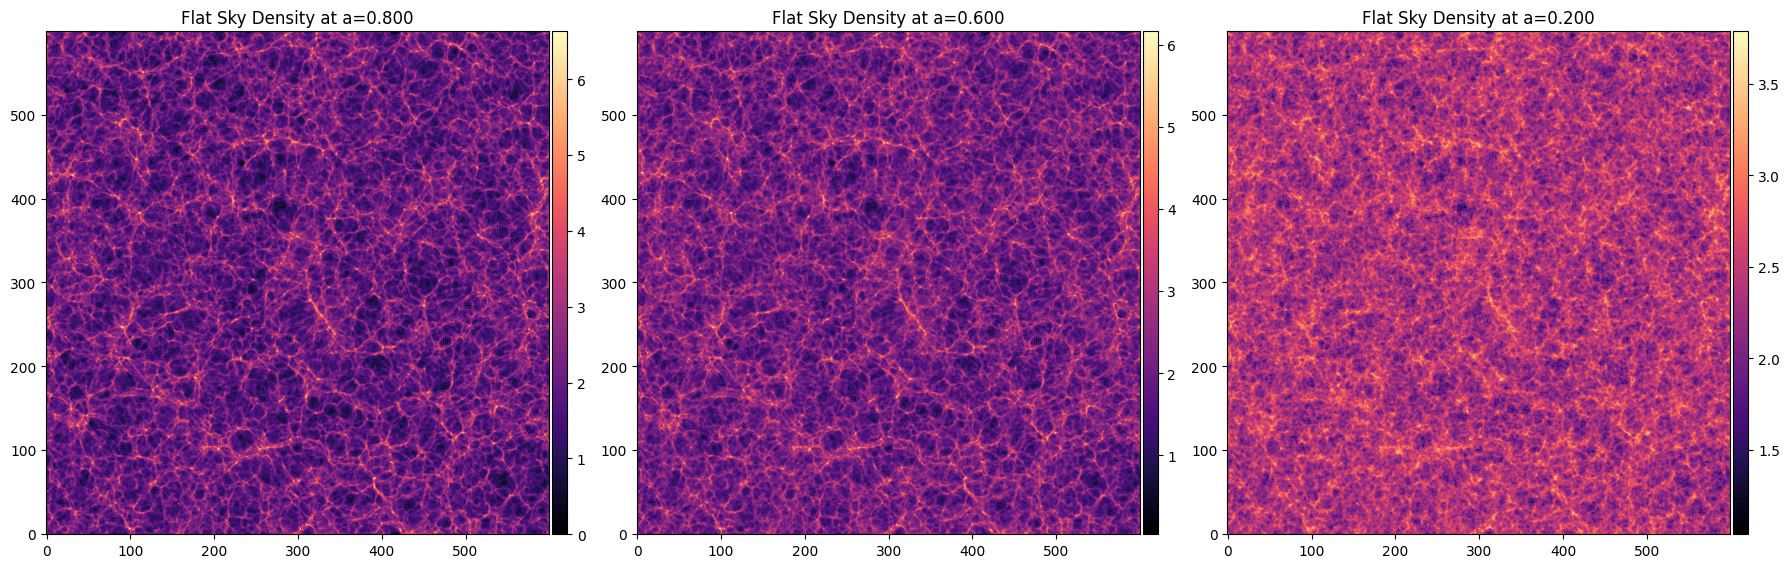

In [3]:
solver = jfli.ReversibleDoubleKickDrift(
    interp_kernel=jfli.NoInterp(painting=jfli.PaintingOptions(target="density")),
)

density_result = jfli.nbody(
    cosmo,
    dx,
    p,
    t1=1.0,
    dt0=0.05,
    ts=ts,
    solver=solver,
)
print(f"KKD output type: {type(density_result).__name__}, shape: {density_result.shape}")
density_result.project().apply_fn(jnp.log1p).show()

The warning mean that in case of projection we will be painting outside of the box

DKK output type: FlatDensity, shape: (3, 600, 600)


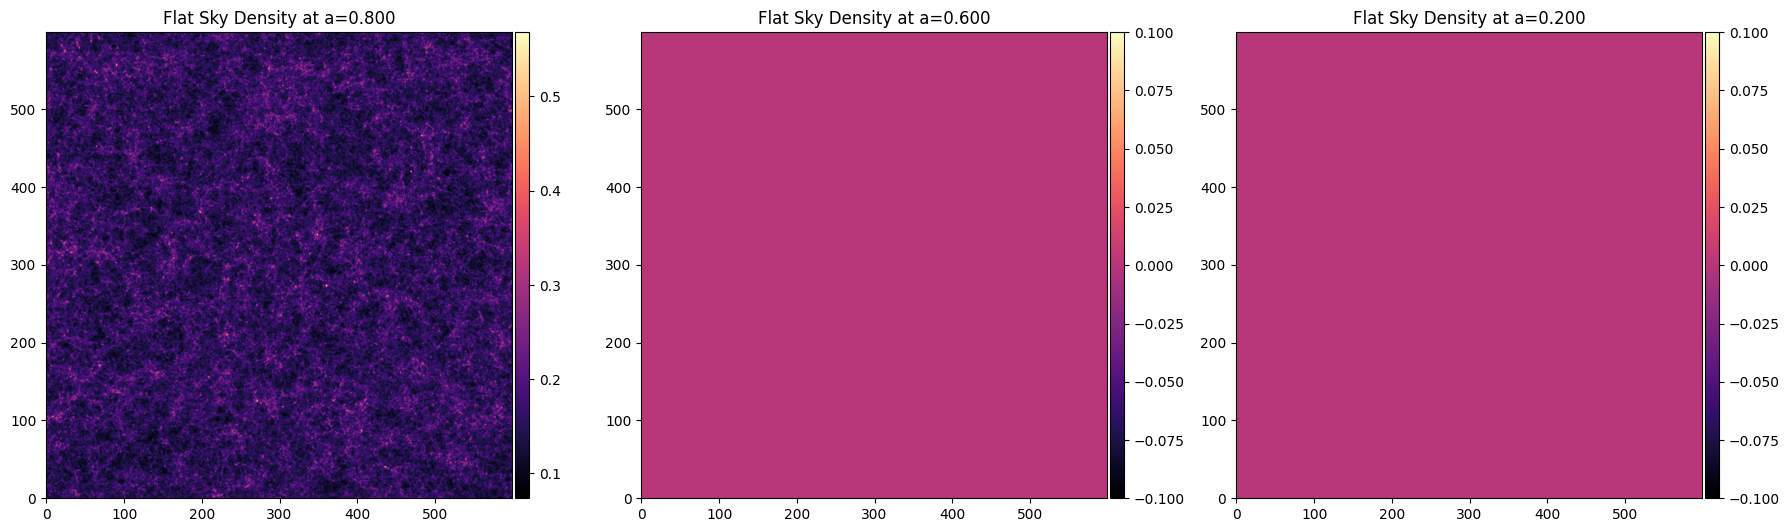

In [4]:
solver_flat = jfli.ReversibleDoubleKickDrift(
    interp_kernel=jfli.NoInterp(painting=jfli.PaintingOptions(target="flat")),
)

result_flat = jfli.nbody(
    cosmo,
    dx,
    p,
    t1=1.0,
    dt0=0.05,
    ts=ts,
    solver=solver_flat,
)
print(f"DKK output type: {type(result_flat).__name__}, shape: {result_flat.shape}")
result_flat.apply_fn(jnp.log1p).show()

KKD output type: SphericalDensity, shape: (3, 4320000)


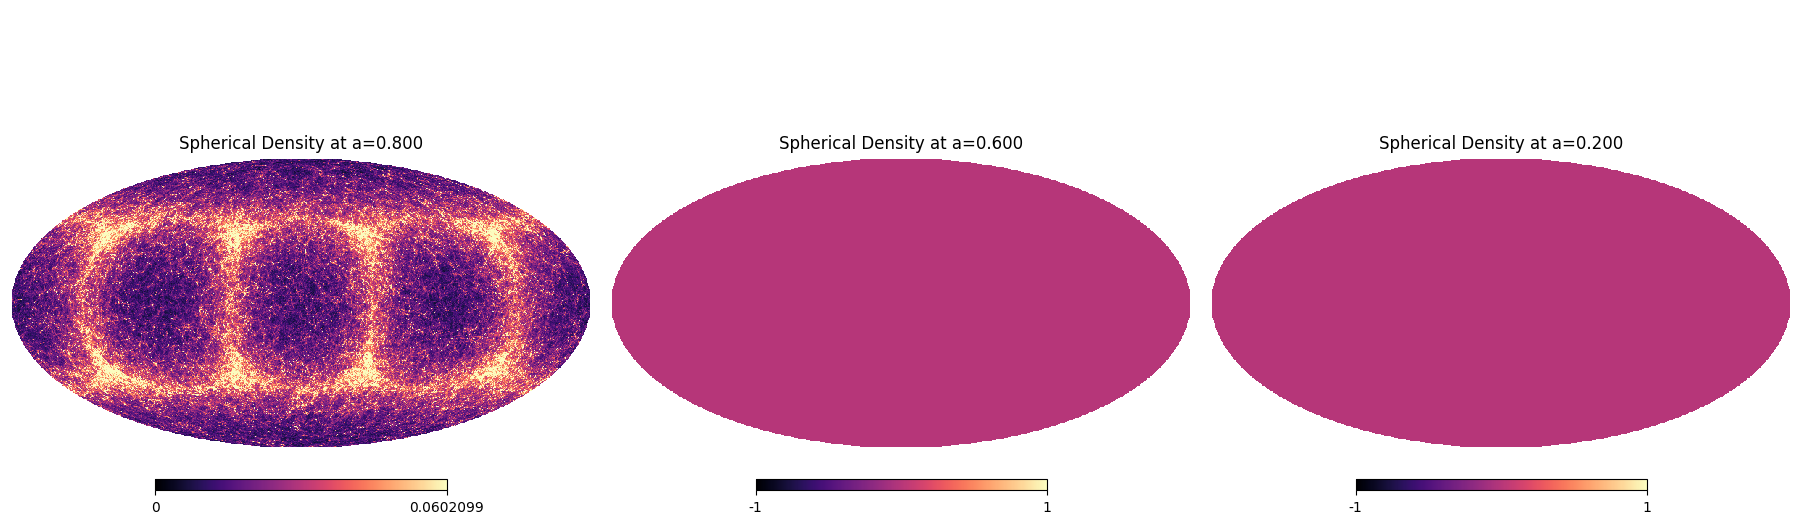

In [5]:
solver_spherical = jfli.ReversibleDoubleKickDrift(
    interp_kernel=jfli.NoInterp(painting=jfli.PaintingOptions(target="spherical")),
)

spherical_results = jfli.nbody(
    cosmo,
    dx,
    p,
    t1=1.0,
    dt0=0.05,
    ts=ts,
    solver=solver_spherical,
)
print(f"KKD output type: {type(spherical_results).__name__}, shape: {spherical_results.shape}")
spherical_results.apply_fn(jnp.log1p).show()

# Making a Correct simulation with a projected field

So a correct simulation must be inside the box or at least user some replication scheme (@CLAUDE SOME other notebook) to make sure that the painting is correct.
You must make sure that the furtherst redshift is inside your box or use the `nb_shells` argument instead of manually specifying the snapshots with `ts`. The `nb_shells` will make sure that the snapshots are equally spaced in comoving distance and that the furthest one is inside the box.

KKD output type: SphericalDensity, shape: (4, 4320000)


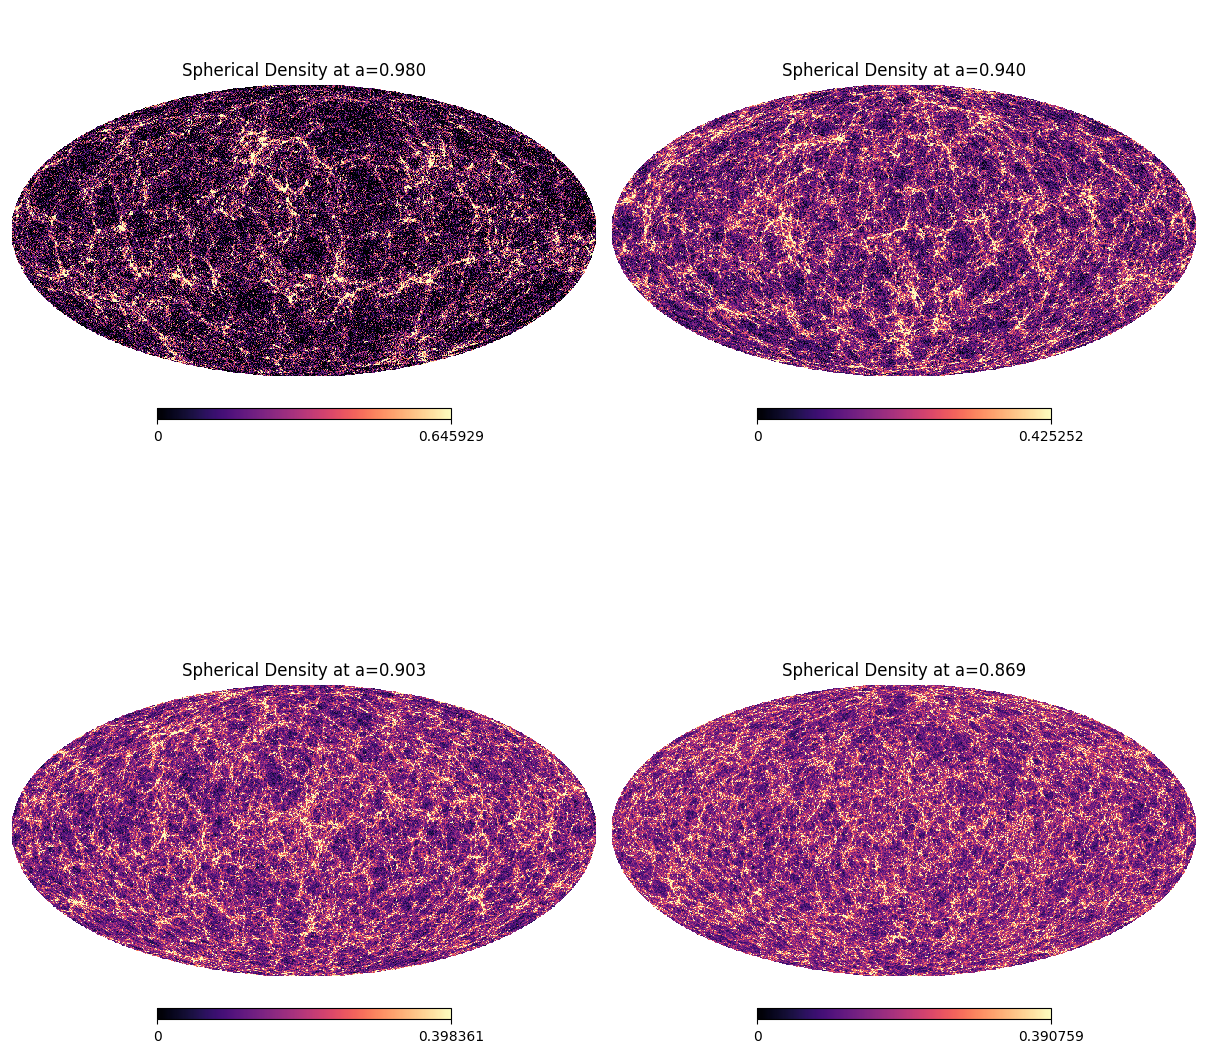

In [6]:
nb_shells = 4

valid_spherical = jfli.nbody(
    cosmo,
    dx,
    p,
    t1=1.0,
    dt0=0.05,
    nb_shells=nb_shells,
    solver=solver_spherical,
)
print(f"KKD output type: {type(valid_spherical).__name__}, shape: {valid_spherical.shape}")
valid_spherical.apply_fn(jnp.log1p).show(ncols=2)

In [7]:
print(f"The snapshots are at redshifts: {valid_spherical.z_sources}")
print(f"Maximum comoving distance of the shells: {valid_spherical.max_comoving_radius:.2f} Mpc/h")
print(
    f"Maximum redshift of the shells: {jc.utils.a2z(jc.background.a_of_chi(cosmo, valid_spherical.max_comoving_radius)).squeeze():.2f}"
)

The snapshots are at redshifts: [0.02084788 0.06338194 0.10684762 0.15131952]
Maximum comoving distance of the shells: 500.00 Mpc/h
Maximum redshift of the shells: 0.17


# Comparing with theory

This does not look very good because the snapshots are very close to the observer and to each other since the box we used so very small (500 Mpc/h) and the furthest redshift is around 0.2 but it is correct and there are no artifacts. If you want to see more structure you can increase the box size or decrease the furthest redshift is less than 0.1

/tmp/ipykernel_256934/1636445686.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


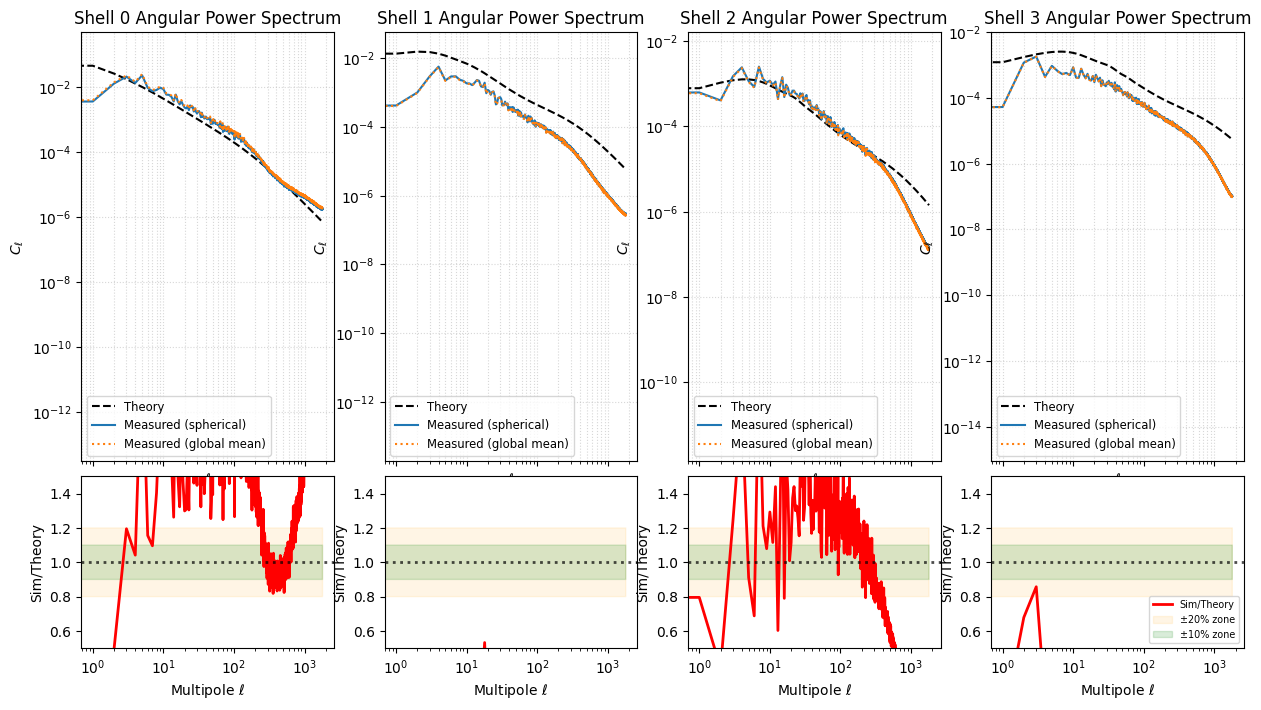

In [8]:
# Measured angular power spectrum
# cl_measured = result_kkd.to(jfli.units.OVERDENSITY).angular_cl(method="healpy")
lc = valid_spherical / valid_spherical.mean(axis=(1,), keepdims=True) - 1.0
cl_measured = lc.angular_cl(method="healpy")
cl_global_mean = valid_spherical.to(jfli.units.OVERDENSITY).angular_cl(method="healpy")

# Theory prediction
LMAX = 3 * nside
ells = jnp.arange(LMAX)
r_center = valid_spherical.comoving_centers
r_width = valid_spherical.density_width
r_near, r_far = r_center - r_width / 2, r_center + r_width / 2
z_near, z_far = jc.utils.a2z(jc.background.a_of_chi(cosmo, jnp.array([r_near, r_far])))

nz_source = [jfli.tophat_z(n, f, gals_per_arcmin2=1.0) for n, f in zip(z_near, z_far)]
theory_cl = jfli.compute_theory_cl(
    cosmo,
    ell=ells,
    z_source=nz_source,
    probe_type="number_counts",
    nonlinear_fn=jc.power.halofit,
    cross=False,
)

fig, axes = plt.subplots(
    2, nb_shells, figsize=(15, 8), sharex="col", gridspec_kw={"height_ratios": [2.5, 1], "hspace": 0.05}
)

for i in range(nb_shells):
    # axes[0, i] is the top row, axes[1, i] is the bottom row
    ax_top = axes[0, i]
    ax_bot = axes[1, i]

    # --- Top Panel: Absolute Power Spectra ---
    theory_cl[i].plot(ax=ax_top, logx=True, logy=True, label="Theory", color="black", linestyle="--")
    cl_measured[i].plot(ax=ax_top, logx=True, logy=True, label="Measured (spherical)")
    cl_global_mean[i].plot(ax=ax_top, logx=True, logy=True, label="Measured (global mean)", linestyle=":")

    ax_top.set_title(f"Shell {i} Angular Power Spectrum")
    ax_top.set_ylabel(r"$C_\ell$")
    ax_top.legend(fontsize="small")

    # --- Bottom Panel: Ratio ---
    ratio = cl_measured[i] / theory_cl[i]

    ax_bot.semilogx(ells, ratio, label="Sim/Theory", color="red", linewidth=2)

    # Reference lines and tolerance zones
    ax_bot.axhline(1, color="black", linestyle=":", alpha=0.7, linewidth=2)
    ax_bot.fill_between(ells, 0.8, 1.2, alpha=0.1, color="orange", label="±20% zone")
    ax_bot.fill_between(ells, 0.9, 1.1, alpha=0.15, color="green", label="±10% zone")

    ax_bot.set_ylim(0.5, 1.5)
    ax_bot.set_xlabel(r"Multipole $\ell$")
    ax_bot.set_ylabel("Sim/Theory")

    # To keep things clean, you might only want the ratio legend on the last plot
    if i == nb_shells - 1:
        ax_bot.legend(loc="lower right", fontsize="x-small")

plt.tight_layout()
plt.show()

In this case we will validate the 3D simulation against the linear power matter spectrum with the halo fit

In [9]:
nb_shells = 4
solver_dens = jfli.ReversibleDoubleKickDrift(
    interp_kernel=jfli.NoInterp(painting=jfli.PaintingOptions(target="density")),
)

density_result = jfli.nbody(
    cosmo,
    dx,
    p,
    t1=1.0,
    dt0=0.05,
    nb_shells=nb_shells,
    solver=solver_dens,
)

In [12]:
key = jax.random.PRNGKey(0)
resolution = 256
mesh_size = (resolution,) * 3
box_size = (1000.0, 1000.0, 1000.0)
nside = resolution
flatsky_npix = (resolution, resolution)
field_size = (10, 10)
nb_shells = 4
cosmo = jc.Planck18()
ts = jnp.array([0.2, 0.6, 0.8])

initial_field = jfli.gaussian_initial_conditions(
    key,
    mesh_size,
    box_size,
    cosmo=cosmo,
    nside=nside,
    flatsky_npix=flatsky_npix,
    field_size=field_size,
)

# LPT at early time to initialize PM
t0 = 0.1
dx, p = jfli.lpt(cosmo, initial_field, ts=t0, order=1, painting=jfli.PaintingOptions(target="particles"))
print(f"LPT initialized at a={t0}")
print(f"Displacement status: {dx.status}")


nb_shells = 4
solver_dens = jfli.ReversibleDoubleKickDrift(
    interp_kernel=jfli.NoInterp(painting=jfli.PaintingOptions(target="density")),
)

density_low_res = jfli.nbody(
    cosmo,
    dx,
    p,
    t1=1.0,
    dt0=0.05,
    nb_shells=nb_shells,
    solver=solver_dens,
)

LPT initialized at a=0.1
Displacement status: FieldStatus.LPT1


In [14]:
pk = density_result.power()
pk_low_res = density_low_res.power()
theory_pk = [
    jax.jit(jc.power.nonlinear_matter_power, static_argnames=["nonlinear_fn"])(
        cosmo, pk.wavenumber, a=a, nonlinear_fn=jc.power.halofit
    )
    for a in density_result.scale_factors
]

/tmp/ipykernel_256934/502821871.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


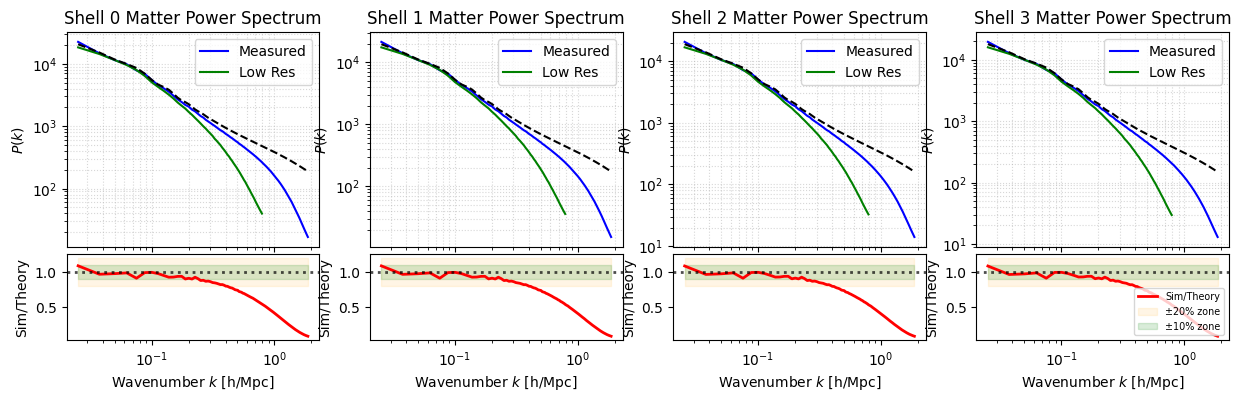

In [16]:
fig, axes = plt.subplots(
    2, nb_shells, figsize=(15, 4), sharex="col", gridspec_kw={"height_ratios": [2.5, 1], "hspace": 0.05}
)

for i in range(nb_shells):
    ax_top = axes[0, i]
    ax_bot = axes[1, i]

    pk[i].plot(ax=ax_top, logx=True, logy=True, label="Measured", color="blue")
    pk_low_res[i].plot(ax=ax_top, logx=True, logy=True, label="Low Res", color="green")
    ax_top.plot(pk.wavenumber, theory_pk[i], label="Theory", color="black", linestyle="--")
    ratio = pk[i] / theory_pk[i]

    ax_bot.semilogx(pk.wavenumber, ratio, label="Sim/Theory", color="red", linewidth=2)
    ax_bot.axhline(1, color="black", linestyle=":", alpha=0.7, linewidth=2)
    ax_bot.fill_between(pk.wavenumber, 0.8, 1.2, alpha=0.1, color="orange", label="±20% zone")
    ax_bot.fill_between(pk.wavenumber, 0.9, 1.1, alpha=0.15, color="green", label="±10% zone")

    ax_top.set_title(f"Shell {i} Matter Power Spectrum")
    ax_top.set_ylabel(r"$P(k)$")
    if i == nb_shells - 1:
        ax_bot.legend(loc="lower right", fontsize="x-small")
    ax_bot.set_xlabel(r"Wavenumber $k$ [h/Mpc]")
    ax_bot.set_ylabel("Sim/Theory")
plt.tight_layout()
plt.show()